In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
batch_size = 32
img_size = (256, 256)

In [3]:
images_directory = '../images/ic'

In [4]:
class_names = ['incorrect', 'correct']

train_ds = tf.keras.utils.image_dataset_from_directory(
  images_directory,
  class_names=class_names,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  images_directory,
  class_names=class_names,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size
)

Found 5810 files belonging to 2 classes.
Using 4648 files for training.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-17 11:00:35.940187: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 11:00:35.940556: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 5810 files belonging to 2 classes.
Using 1162 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['incorrect', 'correct']


2022-11-17 11:00:36.324363: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


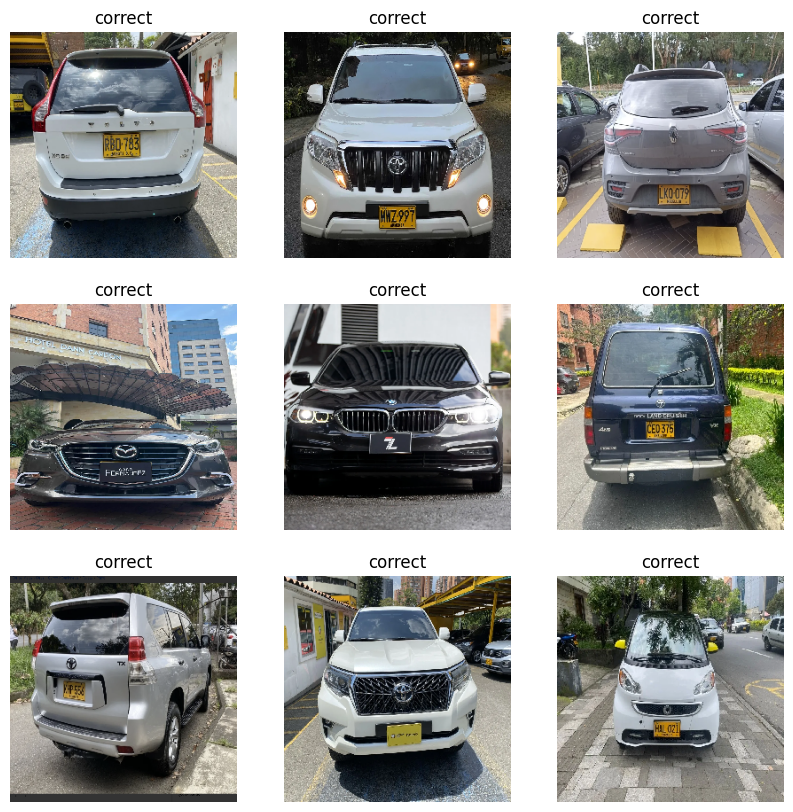

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# callbacks
class AccReached(tf.keras.callbacks.Callback):
  def __init__(self):
    pass
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, mode='min', verbose=1)

ic_check_point_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='models/checkpoints/ic_model.{val_loss:.2f}.h5',
  monitor='val_loss',
  mode='min',
  save_best_only=True,
)
bf_check_point_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='models/checkpoints/bf_model.{val_loss:.2f}.h5',
  monitor='val_loss',
  mode='min',
  save_best_only=True,
)

In [9]:
# learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=0.001,
  decay_steps=10000,
  decay_rate=0.9
  )

In [10]:
ic_model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(3042, activation='relu'),# kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    # tf.keras.layers.Dense(2028, activation='relu'),# kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dense(1014, activation='relu'),# kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dense(512, activation='relu'),# kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dense(128, activation='relu'),# kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dense(64, activation='relu'), # kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
ic_model.compile(
  loss='binary_crossentropy',
  optimizer=tf.optimizers.SGD(learning_rate=lr_schedule),
  metrics=['accuracy'],
)

In [12]:
ic_history = ic_model.fit(
  train_ds,
  steps_per_epoch=len(train_ds),
  epochs=100,
  verbose=1,
  callbacks=[AccReached(), early_stop],
  validation_data=val_ds,
)

Epoch 1/100


2022-11-17 11:00:46.807298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - ETA: 0s - loss: 0.6271 - accuracy: 0.6893

2022-11-17 11:01:17.580840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - 36s 241ms/step - loss: 0.6271 - accuracy: 0.6893 - val_loss: 0.5963 - val_accuracy: 0.6876
Epoch 2/100
146/146 [==============================] - 35s 239ms/step - loss: 0.5606 - accuracy: 0.7149 - val_loss: 0.5609 - val_accuracy: 0.7005
Epoch 3/100
146/146 [==============================] - 35s 239ms/step - loss: 0.4998 - accuracy: 0.7653 - val_loss: 0.4900 - val_accuracy: 0.7556
Epoch 4/100
  1/146 [..............................] - ETA: 57s - loss: 0.3951 - accuracy: 0.9062

KeyboardInterrupt: 